# Acceptance model for B02JpsiKS

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import ROOT
from ROOT import (RooArgSet,
                  RooCategory,
                  RooRealVar,
                  RooDataSet,
                  RooPlot,
                  RooFit,
                  RooStats,
                  RooArgList,
                  RooFormulaVar)

from ROOT import (TFile, 
                  TH1D, 
                  TH2D, 
                  TCanvas, 
                  gStyle, 
                  TLine, 
                  TTree)

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import root_pandas as rp
from root_pandas import read_root
import pandas as pd
            
sys.path.append('/home/vmueller/repos/')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls, build_tchain_from_files
from dopy.doplot.plotting import Plotter, Plot
import dopy.doroot.rootnotes 
from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe

In [2]:
dataset_dir = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks'
 
#new dataset1
dataset_file_name= 'random_sample.root' #'random_sample.root'
dataset_tree_name = 'Bd2JpsiKS'
dataset_file_name = os.path.join(dataset_dir, dataset_file_name) 

# Write true ID as tagging decision to tuple 

In [5]:
Bd2JpsiKS = rp.read_root(dataset_dir+'/random_sample.root', key="Bd2JpsiKS", flatten = False)

In [6]:
var_OS_dec_true = "B0_TRUEID"
Bd2JpsiKS['true_id_tag'] = Bd2JpsiKS[var_OS_dec_true].replace([511,-511],[1,-1])

## Conversion into pico seconds

In [7]:
Bd2JpsiKS['B0_FitPVConst_tau_ps'] = Bd2JpsiKS['B0_FitPVConst_tau_flat'] * 1000
Bd2JpsiKS['B0_FitPVConst_tauErr_ps'] = Bd2JpsiKS['B0_FitPVConst_tau_flat'] * 1000

## Calculate mean mistag 

In [9]:
a = np.array(Bd2JpsiKS['true_id_tag'])[4]

In [10]:
true_tags = np.array(Bd2JpsiKS['true_id_tag'])
real_tags = np.array(Bd2JpsiKS['B0_TAGDECISION_OS'])
correct_tags = 0
incorrect_tags = 0

for i in range(Bd2JpsiKS.shape[0]):
    if (abs(real_tags[i])==1 and real_tags[i]==true_tags[i]):
        correct_tags += 1
    if (abs(real_tags[i])==1 and real_tags[i]!=true_tags[i]):
        incorrect_tags += 1

eta_average = incorrect_tags / (correct_tags+incorrect_tags)
print("The average mistag is: ")
print(eta_average)

The average mistag is: 
0.3648032510655169


In [11]:
Bd2JpsiKS.sample(40000).to_root(dataset_dir + '/random_sample_true_tag.root', key="Bd2JpsiKS")

In [12]:
dataset_file = TFile(dataset_dir + '/random_sample_true_tag.root')
ROOT.SetOwnership(dataset_file, False)

dataset_tree = dataset_file.Get(dataset_tree_name)
ROOT.SetOwnership(dataset_tree, False) 

In [14]:
dataset_dir + '/random_sample_true_tag.root'

'/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/random_sample_true_tag.root'

In [16]:
obsTime     = RooRealVar('B0_FitPVConst_tau_flat', 'obsTime', 0,0.0002, 0.015, 'ns')
obsTimeErr = RooRealVar("B0_FitPVConst_tauErr_flat", "obsTimeErr", 0,-0.001,0.001, "ns")
idxPV = RooRealVar("idxPV", "idxPV", 0,0,0)

ROOT.SetOwnership(obsTime, False)
ROOT.SetOwnership(obsTimeErr, False)
ROOT.SetOwnership(idxPV, False)

obsTagComb = RooCategory("B0_TAGDECISION_OS", "#it{d}_{OS}")
obsTagComb.defineType("B0b", -1)
obsTagComb.defineType("B0",  +1)

#criteria and information for read in mc
data = ROOT.TFile(dataset_dir+'/random_sample_true_tag.root')
tree_data = data.Get('Bd2JpsiKS') 
tree_data.GetEntries()
ntupleVarSet =  RooArgSet(obsTime,obsTimeErr,idxPV,obsTagComb) 
data = RooDataSet('data','data',tree_data,ntupleVarSet)
ROOT.SetOwnership(data,False)

print('Number of entries: '+ str(data.numEntries()))

Number of entries: 13038


In [17]:
#data.numEntries().find(obsTagComb).getIndex() 

In [18]:
subdir = '/home/chasenberg/plots/acceptance'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Build acceptance model

In [19]:
from ROOT import gSystem
gSystem.Load("libRooFit.so")
gSystem.Load("/home/vmueller/repos/dopy/dolib/acceptances/libAcceptances")

0

In [20]:
from ROOT import RooCubicSplineFun
from ROOT import RooResolutionModel 

In [21]:
from ROOT import std
knots = std.vector("double")(5)
knots[0]=(obsTime.getMin()) # 0.0
knots[1]=(0.00025)
knots[2]=(0.0009)
#knots[3]=(0.0007)
knots[3]=(0.004)
#knots[3]=(0.0011)
#knots[5]=(0.013)
knots[4]=(obsTime.getMax()) # 18.0

In [22]:
print(obsTime.getMin(),obsTime.getMax(),len(knots))

0.0002 0.015 5


In [23]:
knotlist = RooArgList("knotlist")
ROOT.SetOwnership(knotlist, False)

# This is needed because 2 extra coefficients are needed
# (assert statement)
for i in range(0,len(knots)+1): # len(knots)+2
    binname = "parTimeAccCSpline" + str(i)
    bintitle = "h_{" + str(i) + "}"
    var = RooRealVar(binname, bintitle,0.01*i,3)
    print(var.getVal())
    #print(str(var.GetName()))
    ROOT.SetOwnership(var, False)
    knotlist.add(var)
    
knotlist.add(knotlist[len(knots)])  

accspline = RooCubicSplineFun("accspline", "Spline Acceptance", obsTime, knots, knotlist)
ROOT.SetOwnership(accspline, False)
#RooCubicSplineFun()

1.5
1.505
1.51
1.515
1.52
1.525


In [24]:
knotlist

<ROOT.RooArgList object ("knotlist") at 0xa446620>

### Build resolution model

### Per event resolution 

In [25]:
from ROOT import RooGaussian, RooAddPdf, RooEffResAddModel,RooGaussEfficiencyModel, RooGaussModel, RooAddModel, RooSimultaneous
from ROOT import (RooArgSet,
                  RooCategory,
                  RooRealVar,
                  RooDataSet,
                  RooPlot,
                  RooFit,
                  RooStats,
                  RooArgList,
                  RooFormulaVar)

from ROOT import (TFile, 
                  TH1D, 
                  TH2D, 
                  TCanvas, 
                  gStyle, 
                  TLine, 
                  TTree)



############################################################################################################
############################################################################################################

parResCondMean  = RooRealVar('parResCondMean', 'parResCondMean', 0,0,0)
ROOT.SetOwnership(parResCondMean, False)

parResCond_a_1 = RooRealVar('parResCond_a_1', 'parResCond_a_1', 0.0009999999999990665,0.0009999999999990665,0.0009999999999990665)
ROOT.SetOwnership(parResCond_a_1, False)
parResCond_b_1 = RooRealVar('parResCond_b_1', 'parResCond_b_1', 3.3829081535105616e-05,3.3829081535105616e-05,3.3829081535105616e-05)
ROOT.SetOwnership(parResCond_b_1, False)


parResCond_a_2 = RooRealVar('parResCond_a_2', 'parResCond_a_2',0.001399996130825779,0.001399996130825779,0.001399996130825779)
ROOT.SetOwnership(parResCond_a_2, False)
parResCond_b_2 = RooRealVar('parResCond_b_2', 'parResCond_b_2',7.2603334480918e-05,7.2603334480918e-05,7.2603334480918e-05)
ROOT.SetOwnership(parResCond_b_2, False)


parResCond_a_3 = RooRealVar('parResCond_a_3', 'parResCond_a_3', 0,0,0)
ROOT.SetOwnership(parResCond_a_3, False)
parResCond_b_3 = RooRealVar('parResCond_b_3', 'parResCond_b_3',0.0004926588599787635,0.0004926588599787635,0.0004926588599787635)
ROOT.SetOwnership(parResCond_b_3, False)





#Definition and calculation of sigma's, related linearly on the decaytime error from the ntuple 
parResCondSigma_1 = RooFormulaVar('parResCondSigma_1', '@0*@1+@2', RooArgList(parResCond_a_1, obsTimeErr, parResCond_b_1))
ROOT.SetOwnership(parResCondSigma_1, False)

parResCondSigma_2 = RooFormulaVar('parResCondSigma_2', '@0*@1+@2', RooArgList(parResCond_a_2, obsTimeErr, parResCond_b_2))
ROOT.SetOwnership(parResCondSigma_2, False)

parResCondSigma_3 = RooFormulaVar('parResCondSigma_3', '@0*@1+@2', RooArgList(parResCond_a_3, obsTimeErr, parResCond_b_3))
ROOT.SetOwnership(parResCondSigma_3, False)
 


#Fractions of particular PDF's  
parResCondFrac_1 = RooRealVar('parResCondFrac_1', 'parResCondFrac_1', 0.6830994163212611,0.6830994163212611,0.6830994163212611)
ROOT.SetOwnership(parResCondFrac_1, False)
parResCondFrac_2 = RooRealVar('parResCondFrac_2', 'parResCondFrac_2', 0.30416780073511007,0.30416780073511007,0.30416780073511007)
ROOT.SetOwnership(parResCondFrac_2, False)
 

pdfEffModel1 = RooGaussEfficiencyModel('pdfEffModel1', 'pdfEffModel1', obsTime, accspline, parResCondMean, parResCondSigma_1)
ROOT.SetOwnership(pdfEffModel1, False)
pdfEffModel2 = RooGaussEfficiencyModel('pdfEffModel2', 'pdfEffModel2', obsTime, accspline,  parResCondMean, parResCondSigma_2)
ROOT.SetOwnership(pdfEffModel2, False)
pdfEffModel3 = RooGaussEfficiencyModel('pdfEffModel3', 'pdfEffModel3', obsTime,  accspline, parResCondMean, parResCondSigma_3)
ROOT.SetOwnership(pdfEffModel3, False) 
 
pdfRes = RooEffResAddModel('pdfRes', 'pdfRes', RooArgList(pdfEffModel1,pdfEffModel2, pdfEffModel3), RooArgList(parResCondFrac_1, parResCondFrac_2))
ROOT.SetOwnership(pdfRes, False)
pdfRes.Print('t')

In [26]:
type(pdfRes)

ROOT.RooEffResAddModel

## Simple average resolution

In [27]:
'''#Build and add two Gaussians for describing the central distribution
mean_1 = RooRealVar("mean", "mean", 0,-0.01,0.01)
mean_1.setConstant()
sigma_1 = RooRealVar("sigma_1", "sigma_1",0.00005,0.00005,0.00005)
sigma_1.setConstant()
pdfRes = RooGaussModel("signal_1","signal_1",obsTime,mean_1,sigma_1)

ROOT.SetOwnership(mean_1,False)
ROOT.SetOwnership(sigma_1,False)
ROOT.SetOwnership(pdfRes,False)'''

'#Build and add two Gaussians for describing the central distribution\nmean_1 = RooRealVar("mean", "mean", 0,-0.01,0.01)\nmean_1.setConstant()\nsigma_1 = RooRealVar("sigma_1", "sigma_1",0.00005,0.00005,0.00005)\nsigma_1.setConstant()\npdfRes = RooGaussModel("signal_1","signal_1",obsTime,mean_1,sigma_1)\n\nROOT.SetOwnership(mean_1,False)\nROOT.SetOwnership(sigma_1,False)\nROOT.SetOwnership(pdfRes,False)'

## Build RooDecay

### Simple approach with perfect tagging

In [28]:
from ROOT import RooBDecay
from ROOT import RooSimultaneous

f0 = RooRealVar("f0", "f0", 1, 0, 2)
f0.setConstant()
f1 = RooRealVar("f1", "f1", 0, -1, 1)
f1.setConstant()

eta_average = RooRealVar("eta_average", "eta_average", 0.366, 0.366, 0.366)
eta_average.setConstant()
parTimeTau = RooRealVar("parTimeTau", "#it{#tau}", 0.001520)#, 1.520, 1.520) #1.520 +- 0.004ps
parDm = RooRealVar("parDm", "parDm", 506.5)
parDGamma = RooRealVar("parDGamma", "parDGamma", 0)

parC = RooRealVar("parC", "parC", 0, -1, 1)
#parC.setConstant()
parS = RooRealVar("parS", "parS", 0.7, -1, 1)
#parS.setConstant()

f2 = RooFormulaVar("f2", "+1.0*@0*(1-2*@1)*@2", RooArgList(obsTagComb, eta_average, parC))
f3 = RooFormulaVar("f3", "-1.0*@0*(1-2*@1)*@2", RooArgList(obsTagComb, eta_average, parS))

#f2 = RooFormulaVar("f2", "+1.0*@0*@1", RooArgList(obsTagComb,parC))
#f3 = RooFormulaVar("f3", "-1.0*@0*@1", RooArgList(obsTagComb,parS))

pdfDecayTime = RooBDecay("simPdf", "simPdf", obsTime, parTimeTau, parDGamma, f0, f1, f2, f3, parDm, pdfRes, RooBDecay.SingleSided)

ROOT.SetOwnership(pdfDecayTime, False)

In [29]:
results_dir = '/home/chasenberg/plots/resolution/results/'

parameters_file_name  = 'params_cond.txt'
parameters_init_name  = parameters_file_name.replace('.txt', '_init.txt')
parameters_final_name = parameters_file_name.replace('.txt', '_final.txt')

if os.path.exists(os.path.join(results_dir, parameters_init_name)):
    print('INFO: Reading parameters from configfile '  + os.path.join(results_dir, parameters_init_name), flush=True)
    data_model_cond.getParameters(data).readFromFile(os.path.join(results_dir, parameters_init_name))
else:
    print('INFO: configfile... '  + os.path.join(results_dir, parameters_init_name) + ' does not exist', flush=True)
    
cond_argset = RooArgSet(obsTimeErr)    


fit_result = pdfDecayTime.fitTo(data, 
                                    RooFit.NumCPU(6),
                                    RooFit.Minimizer('Minuit','minimize'),
                                    RooFit.Hesse(True),
                                    RooFit.Save(True),
                                    RooFit.ConditionalObservables(cond_argset)) 

if fit_result:
    fit_result.Print('v')
    fit_result.correlationMatrix().Print('v')
    if fit_result.status()==0:
        print('INFO: Fit converged')
    else:
        print('INFO: Status '+str(fit_result.status()))
    print('INFO: Fit complete', flush=True)
else:
    print('ERROR: There is no fitresult', flush=True)
 
final_params_file = os.path.join(results_dir, parameters_final_name)
pdfRes.getParameters(data).writeToFile(final_params_file)

INFO: configfile... /home/chasenberg/plots/resolution/results/params_cond_init.txt does not exist
INFO: Fit converged
INFO: Fit complete


In [30]:
parS.getVal(),parS.getError()

(0.5967131764780269, 0.05812000211097679)

In [31]:
parC.getVal(),parC.getError()

(-0.05352009966003268, 0.049714403084540115)

In [32]:
#parS.setVal(0.7)

### Plot RooDecay

INFO: Start plotting
INFO: Finish plotting


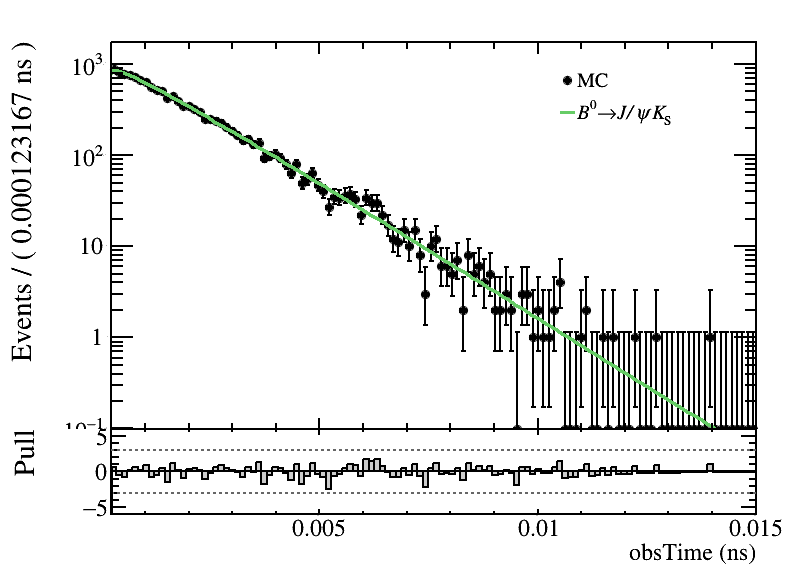

In [33]:
print('INFO: Start plotting', flush=True)
from ROOT import TColor
from root_utils.lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   

decay_set  = ROOT.RooArgSet(pdfDecayTime.getComponents().find('simPdf'))
ROOT.SetOwnership(decay_set, False)

# Prepare frame
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)

plot_frame = obsTime.frame(ROOT.RooFit.Range(0.00022, 0.015), ROOT.RooFit.Bins(120))
#plot_frame.SetMinimum(-100)

ROOT.SetOwnership(plot_frame, False)

data.plotOn(plot_frame, ROOT.RooFit.Name('data'))  
#data.plotOn(plot_frame, RooFit.Cut("true_id_tag==true_id_tag::B0"), ROOT.RooFit.Name('data'))  
pdfDecayTime.plotOn(plot_frame, RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))
#pdfDecayTime.plotOn(plot_frame,RooFit.Slice(obsTagComb,"B0"), RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))


### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.7, 0.7, 0.80, 0.85)
#legend = ROOT.TLegend(0.7, 0.30, 0.80, 0.5)
ROOT.SetOwnership(plot_frame, False)
legend.AddEntry(plot_frame.findObject('data'), 'MC', 'p')
legend.AddEntry(plot_frame.findObject('decay_fit'), '#it{B}^{0}#rightarrow#it{J/#psi}#it{K}_{#kern[-0.3]{S}}', 'l')
legend.SetTextSize(text_size)

plot_frame.GetYaxis().SetRangeUser(0.1, plot_frame.GetMaximum()*1.2)

# Plot pulls
plotname = 'decaytime_mc_blinded'
can,_ = plot_pulls(plotname, plot_frame, drawables=[legend], save_path= subdir + '/plots/', logy=True)
print('INFO: Finish plotting', flush=True)
can

## Plotting Acceptance

In [34]:
nbins = 50
time_min = 0.003#obsTime.getMin()
time_max = obsTime.getMax()

from ROOT import TH1D
hist_obsTime = TH1D('hist_obsTime', 'hist_obsTime', nbins, time_min, time_max)
ROOT.SetOwnership(hist_obsTime, False)

for i in range(data.numEntries()):
    hist_obsTime.Fill(data.get(i).getRealValue('obsTime'))
    
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)
hist_obsTime.Sumw2()
hist_obsTime.Draw()
#canvas   

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canvas


In [35]:
from ROOT import TRandom3

expo = TRandom3(1337)
hist_exp = TH1D('hist_exp', 'hist_exp', nbins, time_min, time_max)

for i in range(0,nbins):
    hist_exp.SetBinContent(i,data.numEntries()*np.exp(-(time_min+(i+0.5)*(time_max-time_min)/nbins)/1.520))

hist_exp.Sumw2()
hist_exp.Draw()
#canvas

In [36]:
hist_obsTime.Sumw2()
hist = TH1D(hist_obsTime)
hist.Divide(hist_exp)
norm_divided = hist.GetSumOfWeights()
hist.Scale(1/100)
hist.Draw()
#canvas

TH1D::Sumw2:0: RuntimeWarning: Sum of squares of weights structure already created


In [37]:
acc_int = accspline.createIntegral(RooArgSet(obsTime))
print(acc_int.getVal())
scale_bin = (time_max-time_min)/nbins
scale = (1/acc_int.getVal())*scale_bin
print(scale)

0.02262440760316001
0.010608012559253864


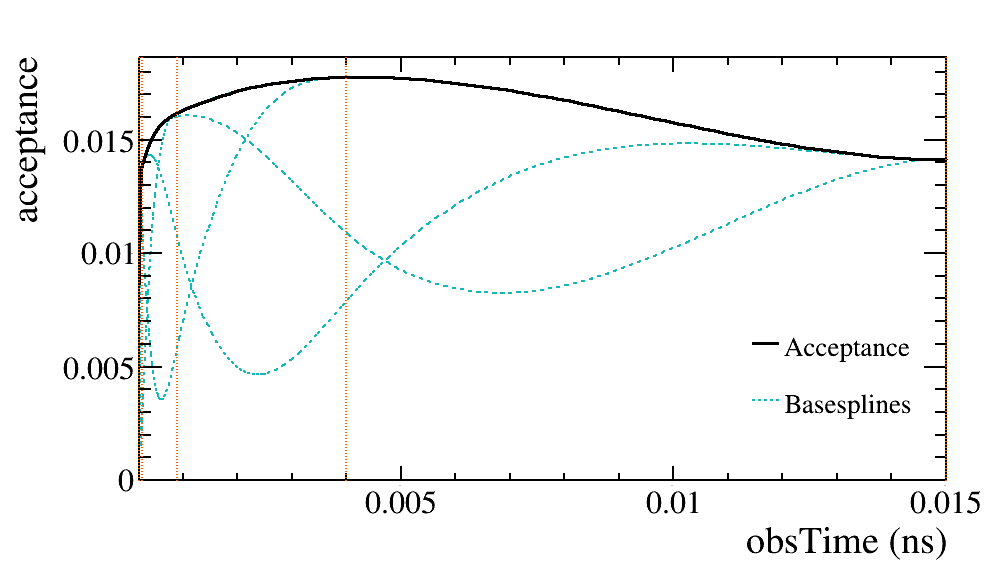

In [38]:
from ROOT import TLine
from ROOT import TLegend

canvas_scaled = TCanvas('canvas_scaled', 'canvas_scaled', 1000, 600)
time_frame = obsTime.frame()
accspline.plotOn(time_frame, RooFit.Normalization(scale),RooFit.LineColor(1))
#time_frame.addTH1(hist)

coeffs = accspline.coefficients()
basesplines = []
lines = []
baselist = RooArgList()

for i,knot in enumerate(knots):
    baselist = coeffs.snapshot()
    for j in range(baselist.getSize()):
        if j==i:
            baselist[i] = coeffs[i] #RooRealVar('blub_'+str(i)+'_'+str(j), 'blub_'+str(i)+'_'+str(j), 1.0)#
            ROOT.SetOwnership(baselist[i], False)
        else:
            baselist[i].setVal(0.0)   
    baselist.Print()        
    basespline = RooCubicSplineFun('csplines'+str(i),'csplines'+str(i), obsTime, knots, baselist)
    basesplines.append(basespline)
    basespline.plotOn(time_frame, RooFit.Normalization(scale), RooFit.LineColor(226), RooFit.LineStyle(2), RooFit.LineWidth(2), RooFit.Name('basespline'))
    line = TLine(knot, 0, knot, time_frame.GetMaximum())
    line.SetLineColor(96)
    line.SetLineStyle(3)
    lines.append(line)

accspline.plotOn(time_frame, RooFit.Normalization(scale),RooFit.LineColor(1), RooFit.Name('accspline'))
time_frame.GetYaxis().SetTitle('acceptance')
time_frame.Draw()
for line in lines:
    line.Draw()
    
### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.75, 0.25, 0.90, 0.45)
#legend.AddEntry(time_frame.findObject('hist_obsTime'), 'MC #it{B}^{0}#rightarrow#it{#psi}(2S)#it{K}_{#kern[-0.3]{S}}', 'p')
legend.AddEntry(time_frame.findObject('accspline'), 'Acceptance', 'l')
legend.AddEntry(time_frame.findObject('basespline'), 'Basesplines', 'l')
legend.SetTextSize(text_size) 
legend.Draw()
#canvas_scaled.SaveAs('/home/chasenberg/plots/acceptance/acceptance_mc.pdf') 
canvas_scaled 

In [39]:
canvas_scaled.SaveAs(subdir + '/plots/'+'acceptance.pdf')